In [12]:
import os; os.environ['OMP_NUM_THREADS'] = '1'
from contextlib import contextmanager
from functools import partial
from operator import itemgetter
from multiprocessing.pool import ThreadPool
import time
from typing import List, Dict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='Set2')

import keras as ks
import pandas as pd
import numpy as np
import tensorflow as tf
#from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split

import lightgbm as lgb

import sys
import gc
path_train = '../input/train_V2.csv'
path_test = '../input/test_V2.csv'

In [2]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
train.head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [ ]:
test.head()

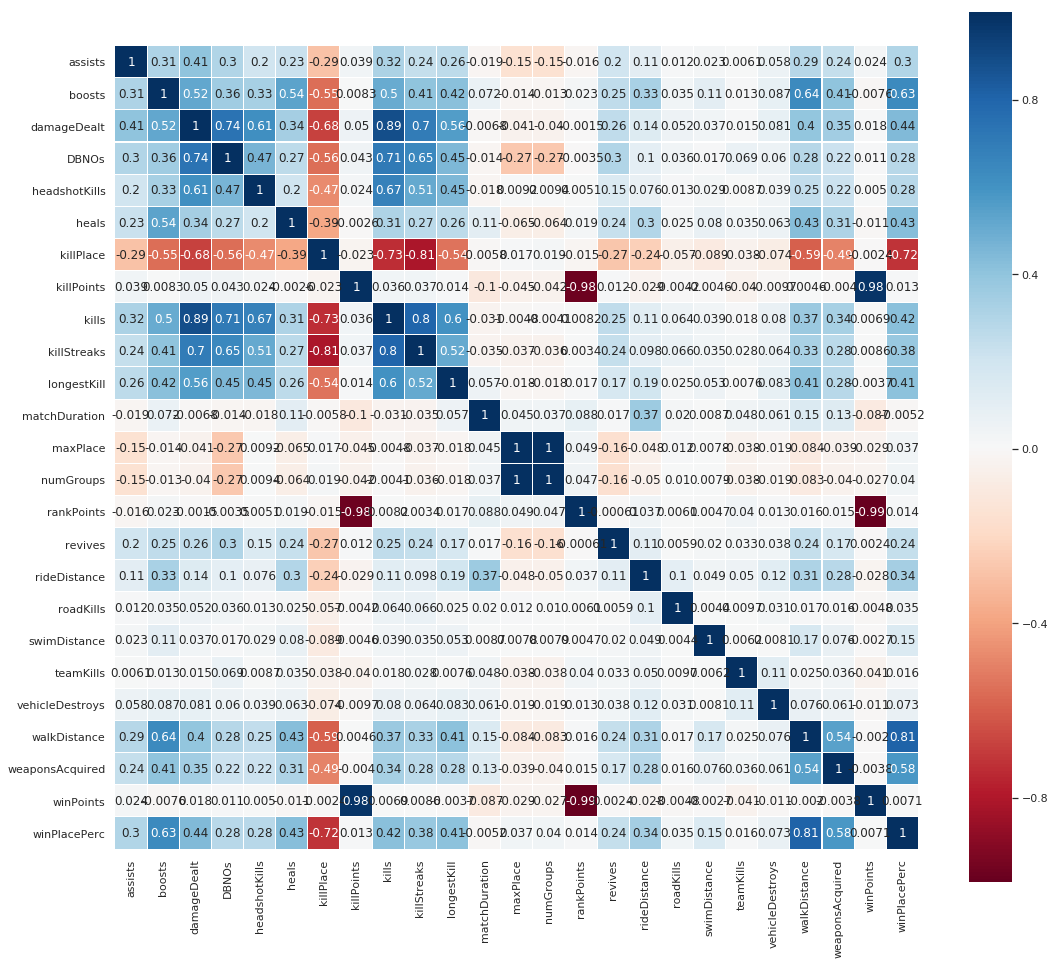

In [13]:
feats = [f for f in train.columns if f not in ["Id","groupId","matchId"]]

plt.figure(figsize=(18,16))
sns.heatmap(train[feats].corr(), linewidths=0.1,vmax=1.0,
               square=True, linecolor='white', annot=True, cmap="RdBu")

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


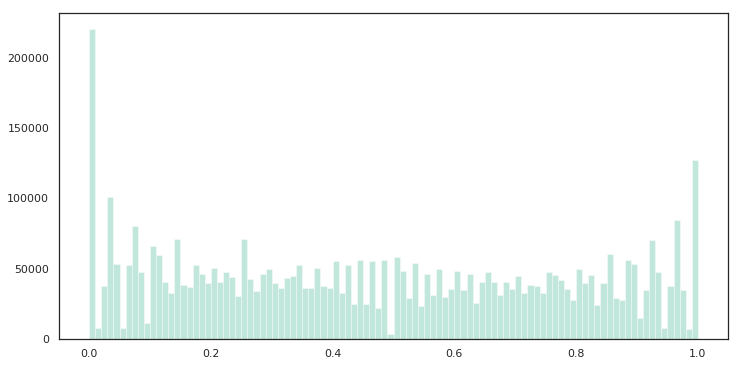

In [15]:
plt.figure(figsize=(12,6))
sns.distplot(train["winPlacePerc"].values,bins=100,kde=False)

In [17]:
#preprocess_data
train = train.drop(["Id","groupId","matchId","matchType"],1)
evaliation = test.drop(["Id","groupId","matchId","matchType"],1)

train_df = train.copy()
full_X = train_df.drop(["winPlacePerc"],1)
full_Y = train_df["winPlacePerc"]

In [18]:
train_X,valid_X,train_Y,valid_Y = train_test_split(full_X,full_Y,test_size=0.2,random_state=42)
train_X.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
4367250,1,0,0.00,0,0,0,80,0,0,0,0.000,1869,26,25,1155,1,0.0,0,0.0,0,0,176.9,2,0
3336275,0,0,0.00,0,0,0,70,0,0,0,0.000,1862,97,93,1529,0,0.0,0,0.0,0,0,119.2,3,0
2374901,0,1,35.23,0,0,5,58,1400,0,0,0.000,1955,94,92,-1,0,1470.0,0,0.0,0,0,828.3,8,1556
1793040,0,2,100.00,0,1,1,28,0,1,1,9.325,1820,96,93,1500,0,0.0,0,0.0,0,0,832.8,5,0
42889,0,1,225.70,0,0,3,58,0,0,0,0.000,1949,45,44,1908,0,1613.0,0,0.0,0,0,1974.0,6,0


In [19]:
train_data = lgb.Dataset(train_X,label=train_Y)
eval_data = lgb.Dataset(valid_X,label=valid_Y,reference=train_data)

In [23]:
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'l2',
    'num_leaves': 144,
    'learning_rate':0.05,
    'feature_fraction': 0.9,                                                                             
    'bagging_fraction': 0.8,                                                                             
    'bagging_freq': 5,   
    'n_estimators': 800,
    'max_depth':12,
    'max_bin':55,
    'verbose':50, 
    'lambda_l2': 2,
}
gbm = lgb.train(params,
               train_data,
               num_boost_round=200,
               valid_sets=eval_data,
               early_stopping_rounds=10
               )

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.31783
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.31783
[3]	valid_0's l2: 0.31783
[4]	valid_0's l2: 0.31783
[5]	valid_0's l2: 0.31783
[6]	valid_0's l2: 0.31783
[7]	valid_0's l2: 0.31783
[8]	valid_0's l2: 0.31783
[9]	valid_0's l2: 0.31783
[10]	valid_0's l2: 0.31783
[11]	valid_0's l2: 0.287912
[12]	valid_0's l2: 0.261561
[13]	valid_0's l2: 0.237755
[14]	valid_0's l2: 0.215576
[15]	valid_0's l2: 0.195557
[16]	valid_0's l2: 0.195557
[17]	valid_0's l2: 0.195557
[18]	valid_0's l2: 0.195557
[19]	valid_0's l2: 0.195557
[20]	valid_0's l2: 0.195557
[21]	valid_0's l2: 0.195557
[22]	valid_0's l2: 0.195557
[23]	valid_0's l2: 0.195557
[24]	valid_0's l2: 0.195557
[25]	valid_0's l2: 0.195557
Early stopping, best iteration is:
[15]	valid_0's l2: 0.195557


In [24]:
pred = gbm.predict(evaliation,num_iteration=gbm.best_iteration)

In [25]:
wPP = pd.Series(data=pred,name="winPlacePerc")
result = pd.DataFrame(index=[test["Id"],wPP])
#result['winPlacePerc'] = pred

In [26]:
result.to_csv("submission.csv",index=False)